Epoch 1/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 317s 368ms/step - accuracy: 0.7994 - loss: 0.5942 - val_accuracy: 0.8970 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 303s 359ms/step - accuracy: 0.8925 - loss: 0.2967 - val_accuracy: 0.8922 - val_loss: 0.2840 - learning_rate: 0.0010
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 232s 274ms/step - accuracy: 0.9079 - loss: 0.2554 - val_accuracy: 0.9135 - val_loss: 0.2331 - learning_rate: 0.0010
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 184s 218ms/step - accuracy: 0.9140 - loss: 0.2388 - val_accuracy: 0.9195 - val_loss: 0.2255 - learning_rate: 0.0010
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 165s 196ms/step - accuracy: 0.9239 - loss: 0.2126 - val_accuracy: 0.9157 - val_loss: 0.2271 - learning_rate: 0.0010
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 167s 198ms/step - accuracy: 0.9299 - loss: 0.1929 - val_accuracy: 0.9268 - val_loss: 0.2004 - learning_rate: 0.0010
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 167s 197ms/step - accura

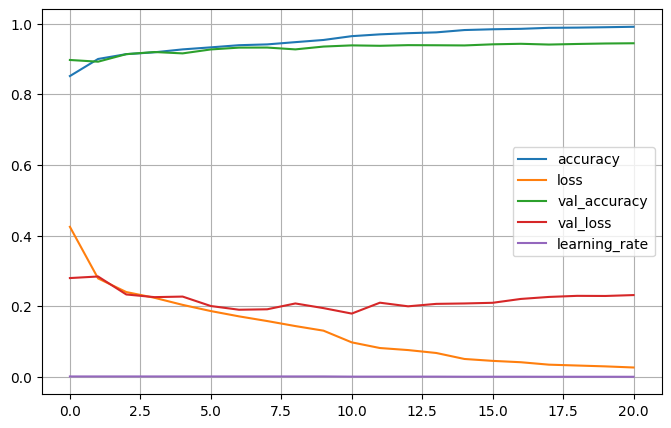

NameError: name 'X_test' is not defined

In [11]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import albumentations as A

# 1. Przygotowanie danych
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = train_labels.astype(np.int32)
test_labels = test_labels.astype(np.int32)

X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=10, stratify=train_labels
)

# Reshape dla Conv2D
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# Dataset z automatycznym prefetch
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(tf.data.AUTOTUNE)

# 2. Definicja modelu
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacki
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint('best_fashion_mnist_model.keras', save_best_only=True)
]

# Trenowanie
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks
)

# Ewaluacja na zbiorze testowym
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')

# Wizualizacja przebiegu uczenia
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

# Zapisywanie modelu
model.save('final_fashion_mnist_model.keras')

#Interfejs predykcji z @tf.function
@tf.function
def predict_fn(model, image):
    return model(image, training=False)

def predict_and_visualize(model, image, true_label):
    class_names = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
    image = image.reshape(1, 28, 28, 1)
    prediction = predict_fn(model, image)
    predicted_class = np.argmax(prediction[0])
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f'Przewidziana klasa: {class_names[predicted_class]}\nPrawdziwa klasa: {class_names[true_label]}')
    plt.axis('off')
    plt.show()
    
    return predicted_class, prediction[0]

sample_idx = 0
sample_image = X_test[sample_idx]
sample_label = y_test[sample_idx]
pred_class, pred_probs = predict_and_visualize(model, sample_image, sample_label)


# 1. Definicja augmentacji (więcej transformacji, ale z umiarem)
transform = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.2),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
], p=1.0)

def augment_image(image):
    # image ma wartości [0,1], zamieniamy na uint8 dla albumentations
    image_uint8 = (image * 255).astype(np.uint8).reshape(28, 28, 1)
    augmented = transform(image=image_uint8)['image']
    # konwersja z powrotem do [0,1]
    return augmented.astype(np.float32).reshape(28, 28) / 255.0

# 2. Generowanie rozszerzonego zbioru treningowego z augmentacją on-the-fly
augmented_images = []
augmented_labels = []

for image, label in zip(X_train, y_train):
    augmented_images.append(image.reshape(28, 28))
    augmented_labels.append(label)
    # generujemy 3 augmentacje na jeden obraz - zwiększamy różnorodność
    for _ in range(3):
        aug_img = augment_image(image)
        augmented_images.append(aug_img)
        augmented_labels.append(label)

augmented_images = np.array(augmented_images).reshape(-1, 28, 28, 1)
augmented_labels = np.array(augmented_labels)

# 3. Tworzymy dataset z batchowaniem i shuffle
batch_size = 128
aug_train_ds = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels)) \
    .shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
aug_val_ds = val_ds  # bez zmian

# 4. Definicja modelu wzorowana na pierwszej części, ale jeszcze mocniejsza architektura
def create_aug_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

aug_model = create_aug_model()

aug_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Callbacki (użyj tych samych z pierwszej części)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_aug_model.keras', save_best_only=True)

# 6. Trenowanie - zwiększamy liczbę epok (np. 50)
history_aug = aug_model.fit(
    aug_train_ds,
    epochs=50,
    validation_data=aug_val_ds,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# 7. Ewaluacja
test_loss, test_accuracy = aug_model.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy (z augmentacją): {test_accuracy:.4f}")

# 8. Predykcja i wizualizacja
@tf.function
def predict_fn(model, image):
    return model(image, training=False)

def predict_and_visualize(model, image, true_label):
    class_names = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
    image = image.reshape(1, 28, 28, 1)
    prediction = predict_fn(model, image)
    predicted_class = np.argmax(prediction[0])

    plt.figure(figsize=(4, 4))
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f'Przewidziana klasa: {class_names[predicted_class]}\nPrawdziwa klasa: {class_names[true_label]}')
    plt.axis('off')
    plt.show()

    return predicted_class, prediction[0]

sample_idx = 0
sample_image = test_images[sample_idx]
sample_label = test_labels[sample_idx]
pred_class, pred_probs = predict_and_visualize(aug_model, sample_image, sample_label)
print(f"Prawdopodobieństwa: {pred_probs.numpy()}")


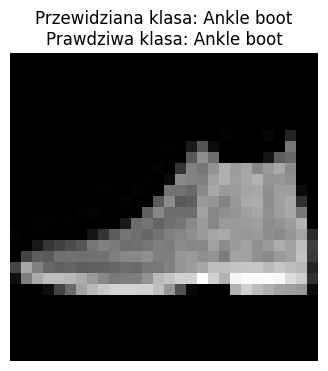

Przewidziana klasa: 9, Prawdopodobieństwa: [1.4492240e-09 6.9341324e-09 4.0801676e-10 2.2398716e-09 5.6290045e-10
 5.0963397e-08 1.4747352e-09 5.3740365e-08 4.3186332e-10 1.0000000e+00]


In [20]:
# Interfejs predykcji z @tf.function
@tf.function
def predict_fn(model, image):
    return model(image, training=False)

def predict_and_visualize(model, image, true_label):
    class_names = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.reshape(image, [1, 28, 28, 1])
    prediction = predict_fn(model, image)
    predicted_class = tf.argmax(prediction[0]).numpy()
    
    plt.figure(figsize=(4, 4))
    plt.imshow(tf.reshape(image, [28, 28]), cmap='gray')
    plt.title(f'Przewidziana klasa: {class_names[predicted_class]}\nPrawdziwa klasa: {class_names[true_label]}')
    plt.axis('off')
    plt.show()
    
    return predicted_class, prediction[0].numpy()

# Przykład predykcji i wizualizacji
sample_idx = 0  # lub dowolny inny indeks
sample_image = test_images[sample_idx]   # poprawione
sample_label = test_labels[sample_idx]   # poprawione
pred_class, pred_probs = predict_and_visualize(model, sample_image, sample_label)

print(f"Przewidziana klasa: {pred_class}, Prawdopodobieństwa: {pred_probs}")
